In [1]:
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import optax
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from sbi_lens.config import config_lsst_y_10

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Copyright 2019 DeepMind Technologies Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Spectral Normalization tools.

This implementation follows the use in:
  https://arxiv.org/abs/1802.05957
  https://arxiv.org/abs/1805.08318
  https://arxiv.org/abs/1809.11096
"""

import re
from typing import Optional

from haiku._src import base
from haiku._src import data_structures
from haiku._src import initializers
from haiku._src import module
import jax
import jax.lax
import jax.numpy as jnp
import haiku as hk



def _l2_normalize(x, axis=None, eps=1e-12):
  """Normalizes along dimension `axis` using an L2 norm.

  This specialized function exists for numerical stability reasons.

  Args:
    x: An input ndarray.
    axis: Dimension along which to normalize, e.g. `1` to separately normalize
      vectors in a batch. Passing `None` views `t` as a flattened vector when
      calculating the norm (equivalent to Frobenius norm).
    eps: Epsilon to avoid dividing by zero.

  Returns:
    An array of the same shape as 'x' L2-normalized along 'axis'.
  """
  return x * jax.lax.rsqrt((x * x).sum(axis=axis, keepdims=True) + eps)


class SpectralNorm(hk.Module):
  """Normalizes an input by its first singular value.

  This module uses power iteration to calculate this value based on the
  input and an internal hidden state.
  """

  def __init__(
      self,
      eps: float = 1e-4,
      n_steps: int = 1,
      val: float = 2,
      name: Optional[str] = None,
  ):
    """Initializes an SpectralNorm module.

    Args:
      eps: The constant used for numerical stability.
      n_steps: How many steps of power iteration to perform to approximate the
        singular value of the input.
      name: The name of the module.
    """
    super().__init__(name=name)
    self.eps = eps
    self.n_steps = n_steps
    self.val = val

  def __call__(
      self,
      value,
      update_stats: bool = True,
      error_on_non_matrix: bool = False,
  ) -> jax.Array:
    """Performs Spectral Normalization and returns the new value.

    Args:
      value: The array-like object for which you would like to perform an
        spectral normalization on.
      update_stats: A boolean defaulting to True. Regardless of this arg, this
        function will return the normalized input. When
        `update_stats` is True, the internal state of this object will also be
        updated to reflect the input value. When `update_stats` is False the
        internal stats will remain unchanged.
      error_on_non_matrix: Spectral normalization is only defined on matrices.
        By default, this module will return scalars unchanged and flatten
        higher-order tensors in their leading dimensions. Setting this flag to
        True will instead throw errors in those cases.
    Returns:
      The input value normalized by it's first singular value.
    Raises:
      ValueError: If `error_on_non_matrix` is True and `value` has ndims > 2.
    """
    value = jnp.asarray(value)
    value_shape = value.shape

    # Handle scalars.
    if value.ndim <= 1:
      raise ValueError("Spectral normalization is not well defined for "
                       "scalar or vector inputs.")
    # Handle higher-order tensors.
    elif value.ndim > 2:
      if error_on_non_matrix:
        raise ValueError(
            f"Input is {value.ndim}D but error_on_non_matrix is True")
      else:
        value = jnp.reshape(value, [-1, value.shape[-1]])

    u0 = hk.get_state("u0", [1, value.shape[-1]], value.dtype,
                      init=hk.initializers.RandomNormal())

    # Power iteration for the weight's singular value.
    for _ in range(self.n_steps):
      v0 = _l2_normalize(jnp.matmul(u0, value.transpose([1, 0])), eps=self.eps)
      u0 = _l2_normalize(jnp.matmul(v0, value), eps=self.eps)

    u0 = jax.lax.stop_gradient(u0)
    v0 = jax.lax.stop_gradient(v0)

    sigma = jnp.matmul(jnp.matmul(v0, value), jnp.transpose(u0))[0, 0]

    value /= sigma
    value *= self.val
    value_bar = value.reshape(value_shape)

    if update_stats:
      hk.set_state("u0", u0)
      hk.set_state("sigma", sigma)

    return value_bar

  @property
  def u0(self):
    return hk.get_state("u0")

  @property
  def sigma(self):
    return hk.get_state("sigma", shape=(), init=jnp.ones)


class SNParamsTree3(hk.Module):
  """Applies Spectral Normalization to all parameters in a tree.

  This is isomorphic to EMAParamsTree in moving_averages.py.
  """

  def __init__(
      self,
      eps: float = 1e-4,
      n_steps: int = 1,
      ignore_regex: str = "",
      val: float=2,
      name: Optional[str] = None,
  ):
    """Initializes an SNParamsTree module.

    Args:
      eps: The constant used for numerical stability.
      n_steps: How many steps of power iteration to perform to approximate the
        singular value of the input.
      ignore_regex: A string. Any parameter in the tree whose name matches this
        regex will not have spectral normalization applied to it. The empty
        string means this module applies to all parameters.
      name: The name of the module.
    """
    super().__init__(name=name)
    self.eps = eps
    self.n_steps = n_steps
    self.ignore_regex = ignore_regex
    self.val = val

  def __call__(self, tree, update_stats=True):
    def maybe_sn(k, v):
      if self.ignore_regex and re.match(self.ignore_regex, k):
        return v
      else:
        sn_name = k.replace("/", "__").replace("~", "_tilde")
        return SpectralNorm(self.eps, self.n_steps, val = self.val, name=sn_name)(
            v, update_stats=update_stats)

    # We want to potentially replace params with Spectral Normalized versions.
    new_values = {}
    for module_name, param_dict in tree.items():
      new_values[module_name] = {
          k: maybe_sn("/".join([module_name, k]), v)
          for k, v in param_dict.items()
      }
    return hk.data_structures.to_haiku_dict(new_values)

In [3]:
total_steps = 500_000
sbi_method = 'nle'
batch_size = 256
params_name = config_lsst_y_10.params_name_latex

In [4]:
if sbi_method == "npe":
    dataset = np.load(
            "gpfswork/rech/eqw/ufa23yn/ssnpe_desc_project/data/LOADED&COMPRESSED_year_10_with_noise_score_density.npz",
            allow_pickle=True,
        )["arr_0"]

elif sbi_method == "nle":
    dataset = np.load(
            "./LOADED&COMPRESSED_year_10_with_noise_score_conditional_very_large.npz",
            allow_pickle=True,
        )["arr_0"]


inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])
dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)
dataset_y_train = dataset_y[:len(dataset_score) - 2000]
dataset_score_train = dataset_score[:len(dataset_score) - 2000]
dataset_theta_train = dataset_theta[:len(dataset_score) - 2000]

dataset_y_test = dataset_y[len(dataset_score) - 2000:]
dataset_score_test = dataset_score[len(dataset_score) - 2000:]
dataset_theta_test = dataset_theta[len(dataset_score) - 2000:]

In [5]:
len(dataset_y_train)

450589

In [6]:
class MomentNetwork(hk.Module):
    
    def __init__(
        self, 
        *args, 
        layers=[128, 128],
        batch_norm = [None, None],
        activation=jax.nn.leaky_relu, 
        **kwargs
    ):
        self.layers = layers
        self.bn = batch_norm
        self.activation = activation
        super().__init__(*args, **kwargs)
 
    def __call__(self, theta, y, is_training):
        
        net = jnp.concatenate([theta, y], axis = -1)
        for i, layer_size in enumerate(self.layers):
            net = self.activation(hk.Linear(layer_size, name="layer%d" % i)(net))
            if self.bn[i] != None:
                net = self.bn[i](net, is_training)
            
        net = hk.Linear(6)(net)

        return net.squeeze()

In [7]:
nb_layer = 5

get_moments = hk.without_apply_rng(
    hk.transform_with_state(
        lambda theta, y : MomentNetwork(
            layers = [128]* nb_layer, 
            batch_norm = [hk.BatchNorm(True, True, 0.999) for i in range(nb_layer)]
        )(theta, y, is_training=True)
    )
)

# Predict esperance

In [8]:
@jax.jit
def loss_esperance(params, state_bn, theta, y, score):

  out, state_bn = get_moments.apply(params, state_bn, theta, y)

  return jnp.sum((out - score) ** 2, axis=-1).mean() / 1000, state_bn

@jax.jit
def update_esperance(params, opt_state, state_bn, sn_state, theta, y, score):
    """Single SGD update step."""
    (loss, state_bn), grads = jax.value_and_grad(loss_esperance, has_aux = True)(
        params, state_bn, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state, state_bn, sn_state

In [9]:
rng_seq = hk.PRNGSequence(12)
params_esperance, state_bn = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

sn_fn = hk.transform_with_state(lambda x: SNParamsTree3(val=2, ignore_regex='[^?!.]*b$|[^?!.]*offset$')(x))
_, sn_state = sn_fn.init(next(rng_seq), params_esperance)

nb_steps = total_steps - total_steps * 0.3

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 60,
        decay_rate=0.9,
        end_value=1e-6,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_esperance = optimizer.init(params_esperance)

batch_loss = []
val_loss = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_score_train), batch_size)
    inds2 = np.random.randint(0, len(dataset_score_test), batch_size)
    ex_score = dataset_score_train[inds]
    ex_theta = dataset_theta_train[inds]
    ex_y = dataset_y_train[inds]

    l, params_esperance, opt_state_esperance, state_bn, sn_state = update_esperance(
        params_esperance, opt_state_esperance, state_bn, sn_state, ex_theta, ex_y, ex_score
    )


    if batch % 500 == 0:
      batch_loss.append(l)
      val_loss.append(
          loss_esperance(
              params_esperance, 
              state_bn,
              dataset_theta_test[inds2], 
              dataset_y_test[inds2],
              dataset_score_test[inds2]
          )[0]
      )
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 382.163: 100%|██████████| 500001/500001 [10:10<00:00, 819.16it/s] 


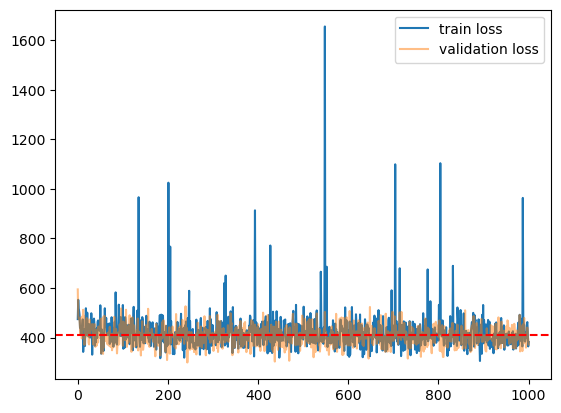

In [10]:
plt.plot(batch_loss, label = 'train loss')
plt.plot(val_loss, alpha = 0.5, label = 'validation loss')
plt.axhline(410, linestyle = '--', c = 'red')
plt.legend()
plt.savefig( "./SNR_study/loss.png")

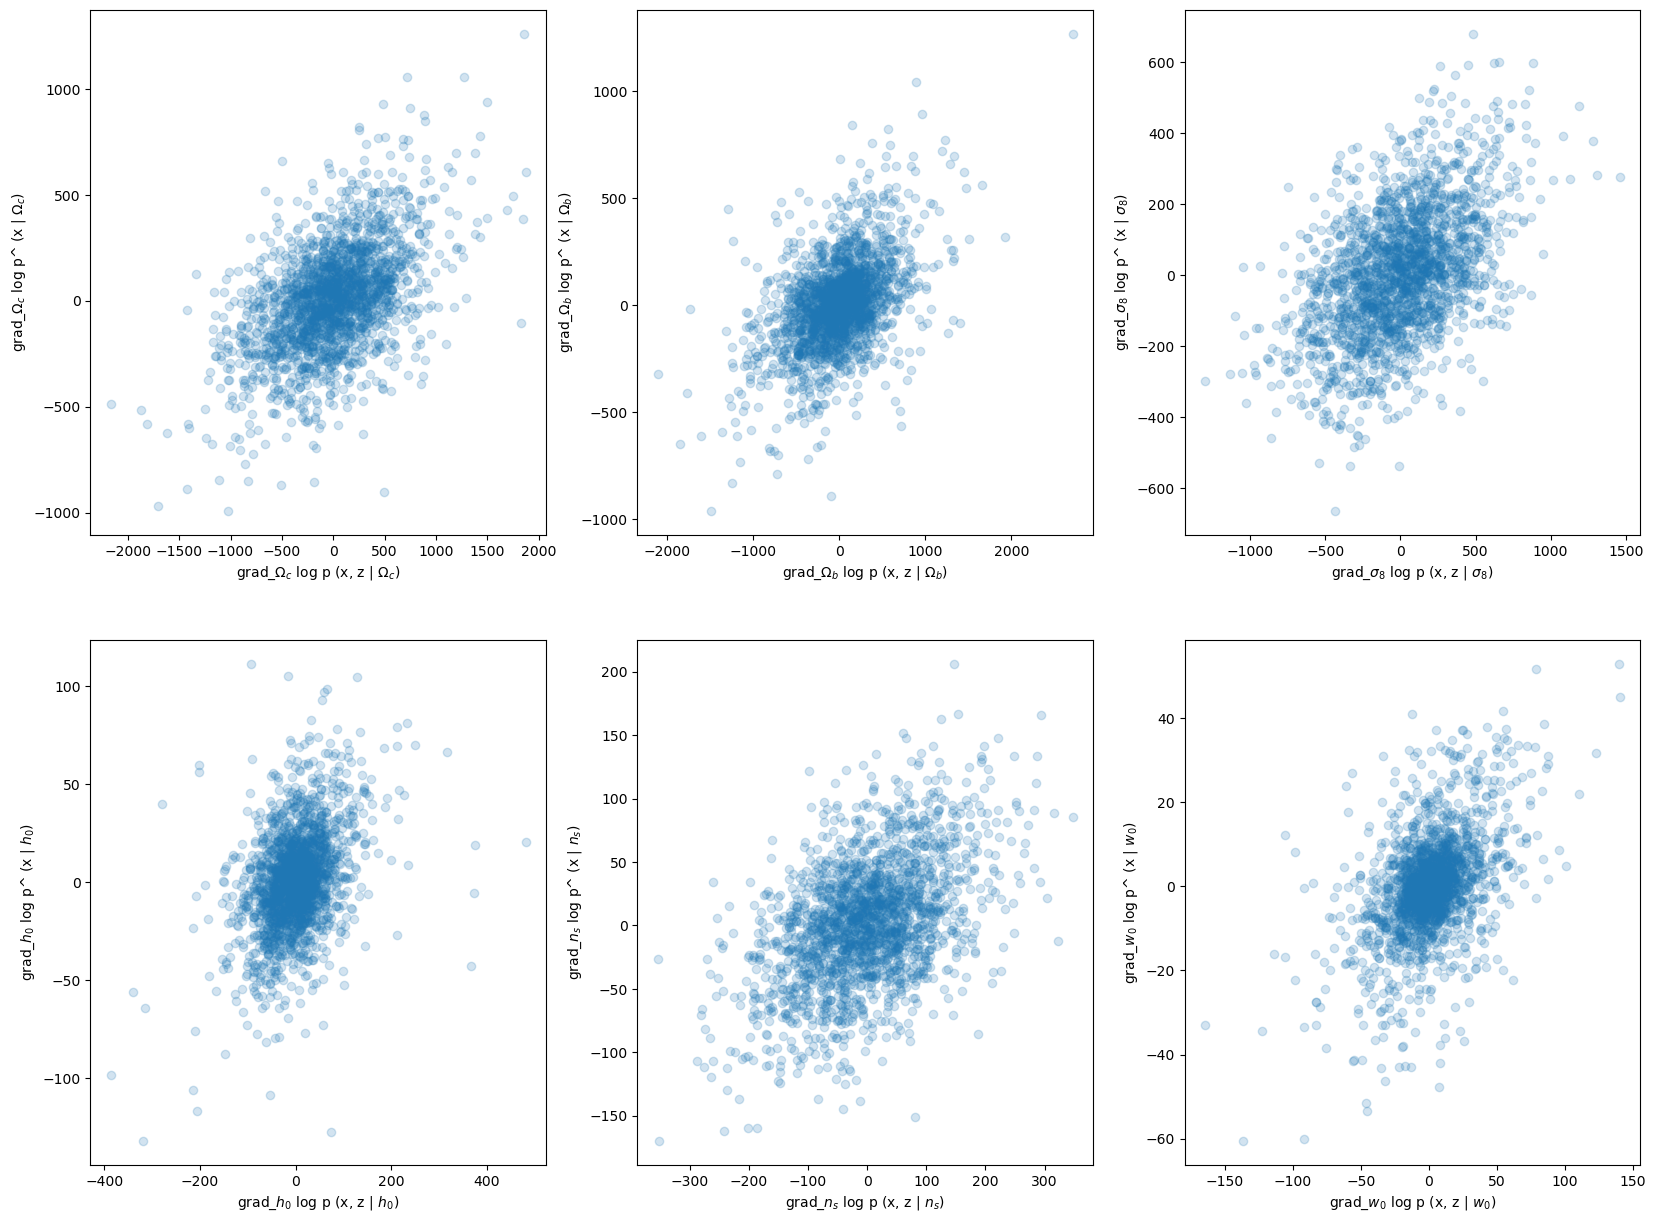

In [11]:
# check regression on test set
get_moments_fixed = hk.without_apply_rng(
    hk.transform_with_state(
        lambda theta, y : MomentNetwork(
            layers = [128]* nb_layer, 
            batch_norm = [hk.BatchNorm(True, True, 0.999) for i in range(nb_layer)]
        )(theta, y, is_training=False)
    )
)

prediction, _ = get_moments_fixed.apply(
    params_esperance, 
    state_bn,
    dataset_theta_test,
    dataset_y_test
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_test[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

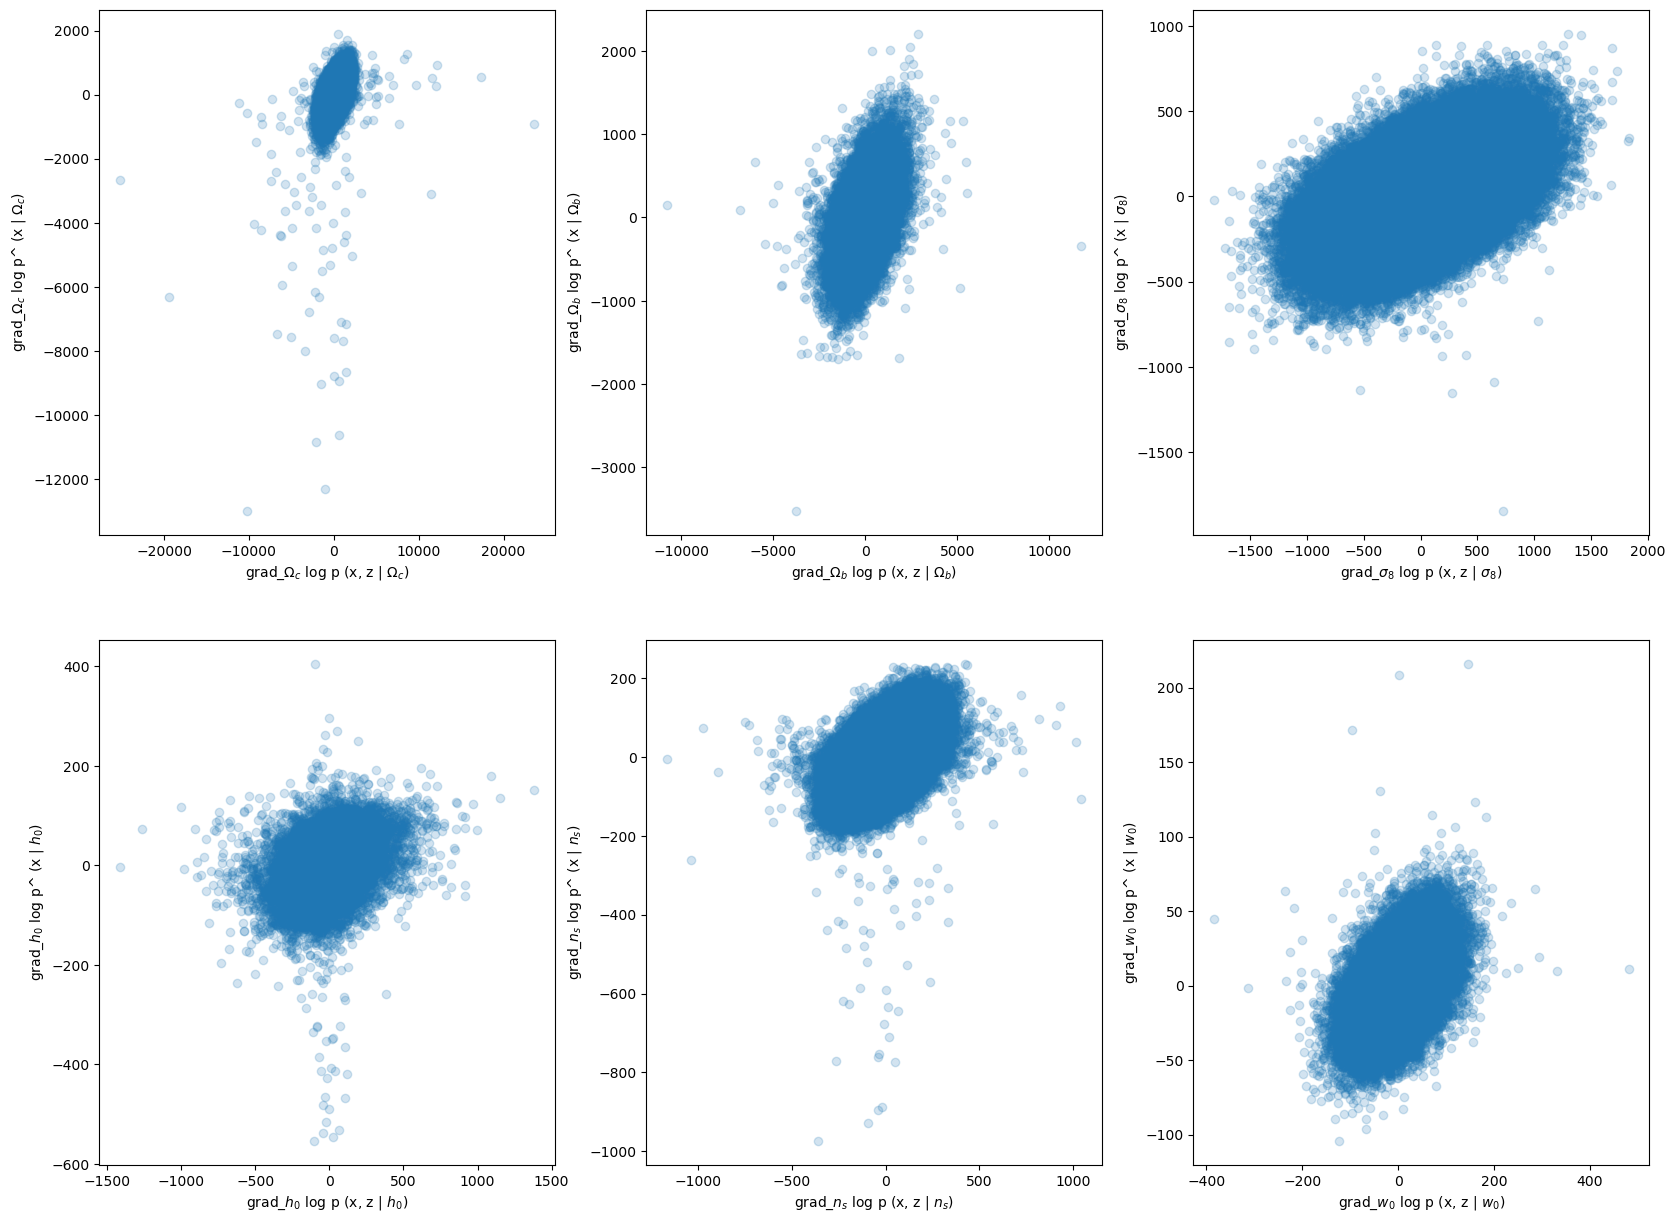

In [12]:
# check regression on train set

prediction, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_train,
    dataset_y_train
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_train[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

In [13]:
with open(
   "./SNR_study/params_esp.pkl", "wb"
) as fp:
    pickle.dump(params_esperance, fp)

In [14]:
state_bn_esp = state_bn

### try with spectral norm

In [15]:
@jax.jit
def loss_esperance(params, state_bn, theta, y, score):

  out, state_bn = get_moments.apply(params, state_bn, theta, y)

  return jnp.sum((out - score) ** 2, axis=-1).mean() / 1000, state_bn

@jax.jit
def update_esperance_with_spectral_norm(params, opt_state, state_bn, sn_state, theta, y, score):
    """Single SGD update step."""
    (loss, state_bn), grads = jax.value_and_grad(loss_esperance, has_aux = True)(
        params, state_bn, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    new_params, sn_state = sn_fn.apply(None, sn_state, None, new_params)

    return loss, new_params, new_opt_state, state_bn, sn_state

In [16]:
rng_seq = hk.PRNGSequence(12)
params_esperance, state_bn = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

sn_fn = hk.transform_with_state(lambda x: SNParamsTree3(val=2, ignore_regex='[^?!.]*b$|[^?!.]*offset$')(x))
_, sn_state = sn_fn.init(next(rng_seq), params_esperance)

nb_steps = total_steps - total_steps * 0.3

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 60,
        decay_rate=0.9,
        end_value=1e-6,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_esperance = optimizer.init(params_esperance)

batch_loss = []
val_loss = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_score_train), batch_size)
    inds2 = np.random.randint(0, len(dataset_score_test), batch_size)
    ex_score = dataset_score_train[inds]
    ex_theta = dataset_theta_train[inds]
    ex_y = dataset_y_train[inds]

    l, params_esperance, opt_state_esperance, state_bn, sn_state = update_esperance_with_spectral_norm(
        params_esperance, opt_state_esperance, state_bn, sn_state, ex_theta, ex_y, ex_score
    )


    if batch % 500 == 0:
      batch_loss.append(l)
      val_loss.append(
          loss_esperance(
              params_esperance, 
              state_bn,
              dataset_theta_test[inds2], 
              dataset_y_test[inds2],
              dataset_score_test[inds2]
          )[0]
      )
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 602.064: 100%|██████████| 500001/500001 [10:36<00:00, 786.00it/s] 


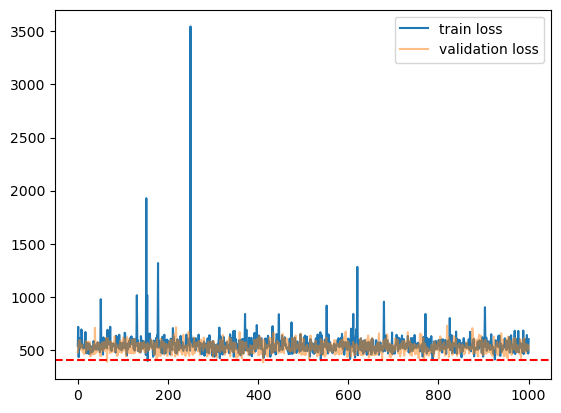

In [17]:
plt.plot(batch_loss, label = 'train loss')
plt.plot(val_loss, alpha = 0.5, label = 'validation loss')
plt.axhline(410, linestyle = '--', c = 'red')
plt.legend()
plt.savefig( "./SNR_study/loss.png")

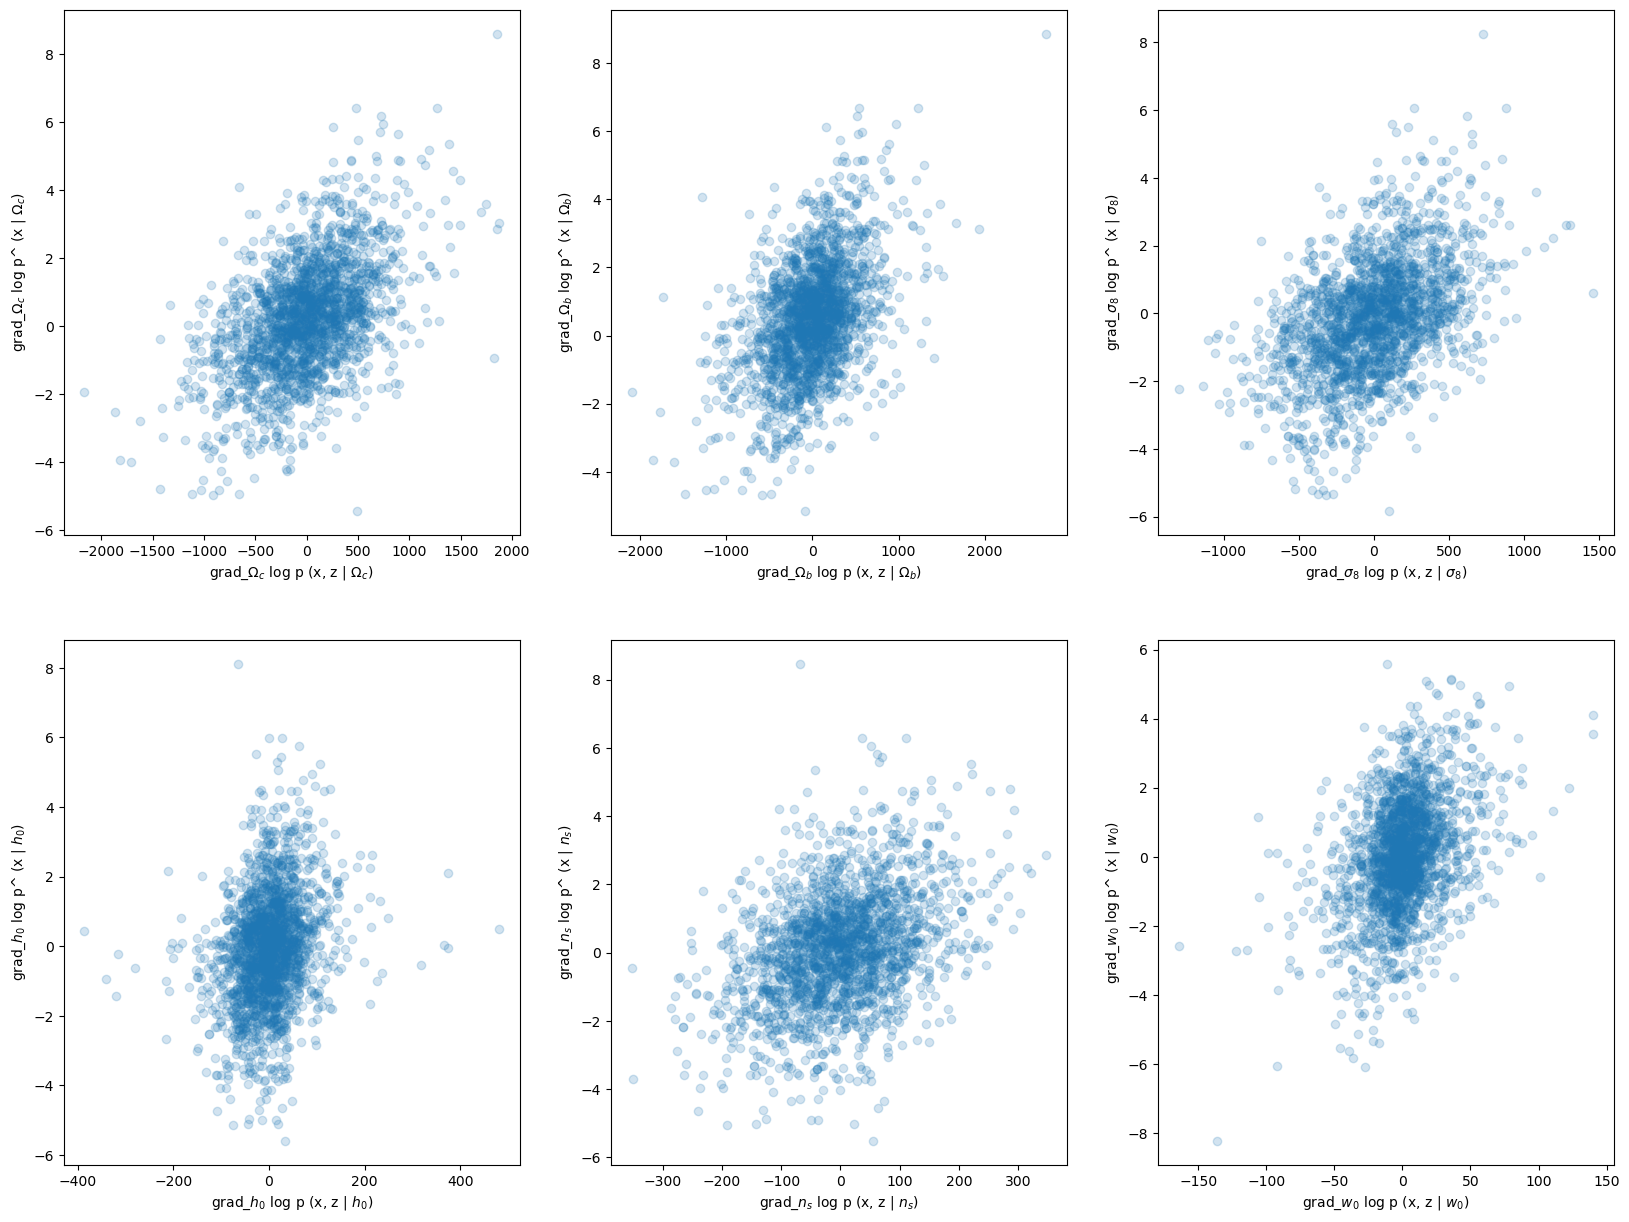

In [18]:
# check regression on test set
get_moments_fixed = hk.without_apply_rng(
    hk.transform_with_state(
        lambda theta, y : MomentNetwork(
            layers = [128]* nb_layer, 
            batch_norm = [hk.BatchNorm(True, True, 0.999) for i in range(nb_layer)]
        )(theta, y, is_training=False)
    )
)

prediction, _ = get_moments_fixed.apply(
    params_esperance, 
    state_bn,
    dataset_theta_test,
    dataset_y_test
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_test[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

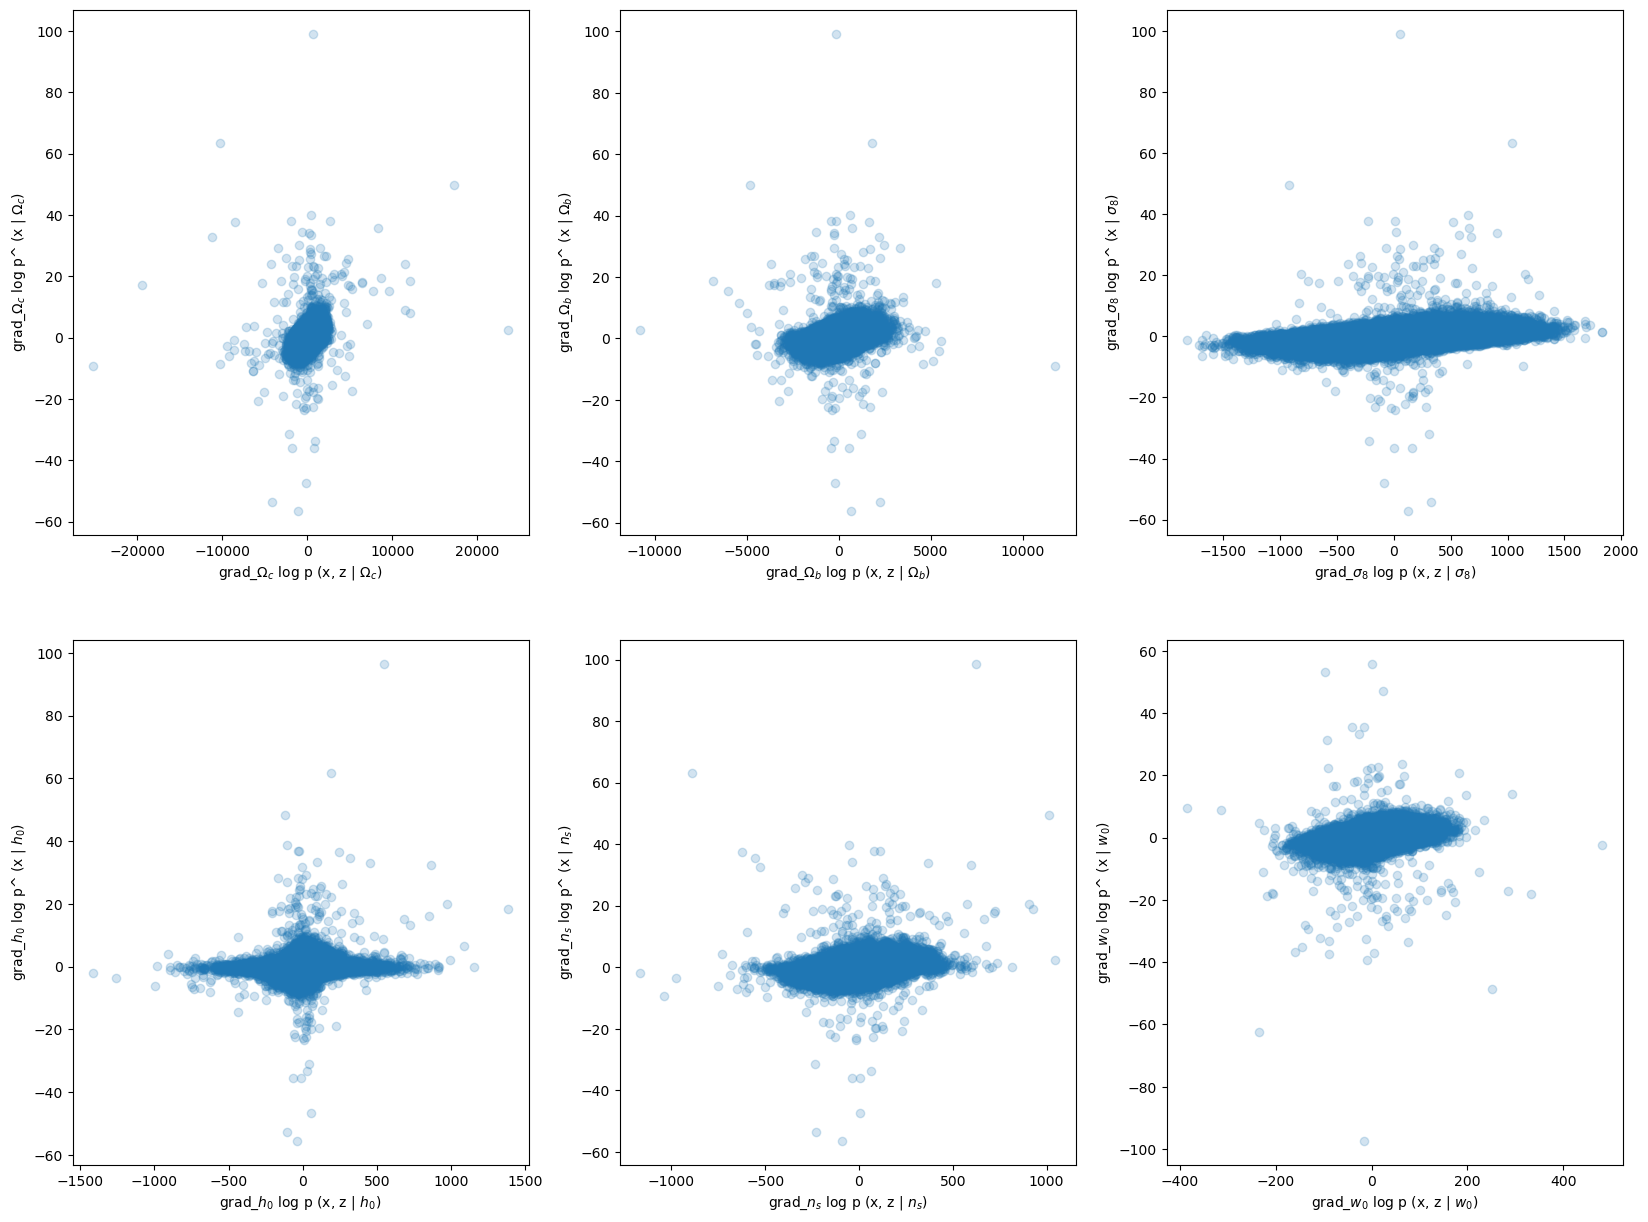

In [19]:
# check regression on train set

prediction, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_train,
    dataset_y_train
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_train[...,i], prediction[...,i], alpha = 0.2)
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression.png")

# Predict std

In [63]:
@jax.jit
def loss_std(params, state_bn, theta, y, score):

    approx_esp, _ = get_moments_fixed.apply(params_esperance, state_bn_esp, theta, y)
    approx_std, state_bn = get_moments.apply(params, state_bn, theta, y)
    approx_var = approx_std ** 2
    var = (approx_esp - score) ** 2

    return jnp.sum((var - approx_var) ** 2, axis=-1).mean() / 1000, state_bn


@jax.jit
def update_std(params, opt_state, state_bn, theta, y, score):
    """Single SGD update step."""
    (loss, state_bn), grads = jax.value_and_grad(loss_std, has_aux=True)(
        params, state_bn, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state, state_bn

In [64]:
rng_seq = hk.PRNGSequence(10)
params_std, state_bn_std = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

nb_steps = total_steps  - total_steps * 0.3

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 60,
        decay_rate=0.9,
        end_value=1e-6,
    )

optimizer = optax.adam(lr_scheduler)
opt_state_std = optimizer.init(params_std)

batch_loss_std = []
val_loss_std = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

for batch in pbar:
    inds = np.random.randint(0, len(dataset_score_train), batch_size)
    inds2 = np.random.randint(0, len(dataset_score_test) - 1, batch_size)
    ex_score = dataset_score_train[inds]
    ex_theta = dataset_theta_train[inds]
    ex_y = dataset_y_train[inds]

    l, params_std, opt_state_std, state_bn_std = update_std(
        params_std, opt_state_std, state_bn_std, ex_theta, ex_y, ex_score
    )

    if batch % 500 == 0:
      batch_loss_std.append(l)
      val_loss_std.append(
          loss_std(
              params_std, 
              state_bn_std,
              dataset_theta_test[inds2], 
              dataset_y_test[inds2],
              dataset_score_test[inds2]
          )[0]
      )
      lr_scheduler_store.append(lr_scheduler(batch))
      pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 136737072.000:  52%|█████▏    | 516254/1000001 [10:15<09:36, 838.94it/s] 


KeyboardInterrupt: 

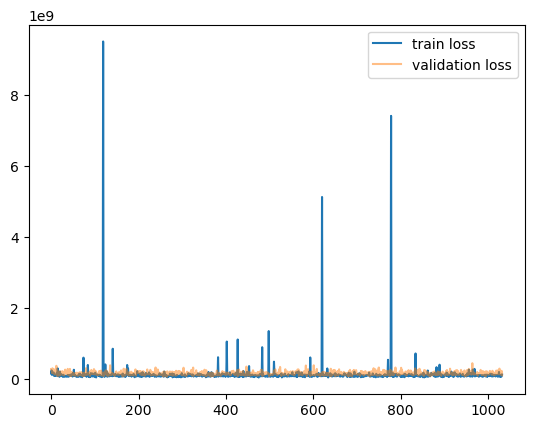

In [65]:
plt.plot(batch_loss_std, label = 'train loss')
plt.plot(val_loss_std, alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std.png")

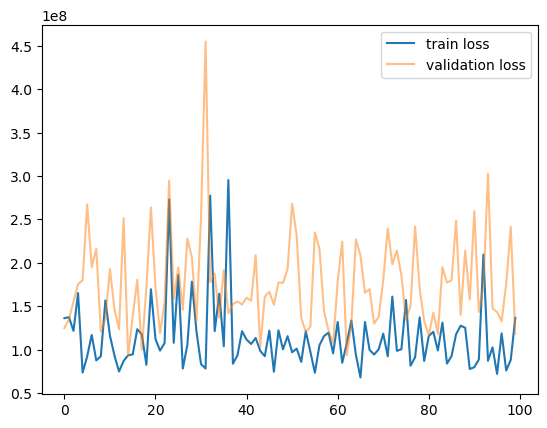

In [66]:
plt.plot(batch_loss_std[-100:], label = 'train loss')
plt.plot(val_loss_std[-100:], alpha = 0.5, label = 'validation loss')
plt.legend()
plt.savefig( "./SNR_study/loss_std_zoom.png")

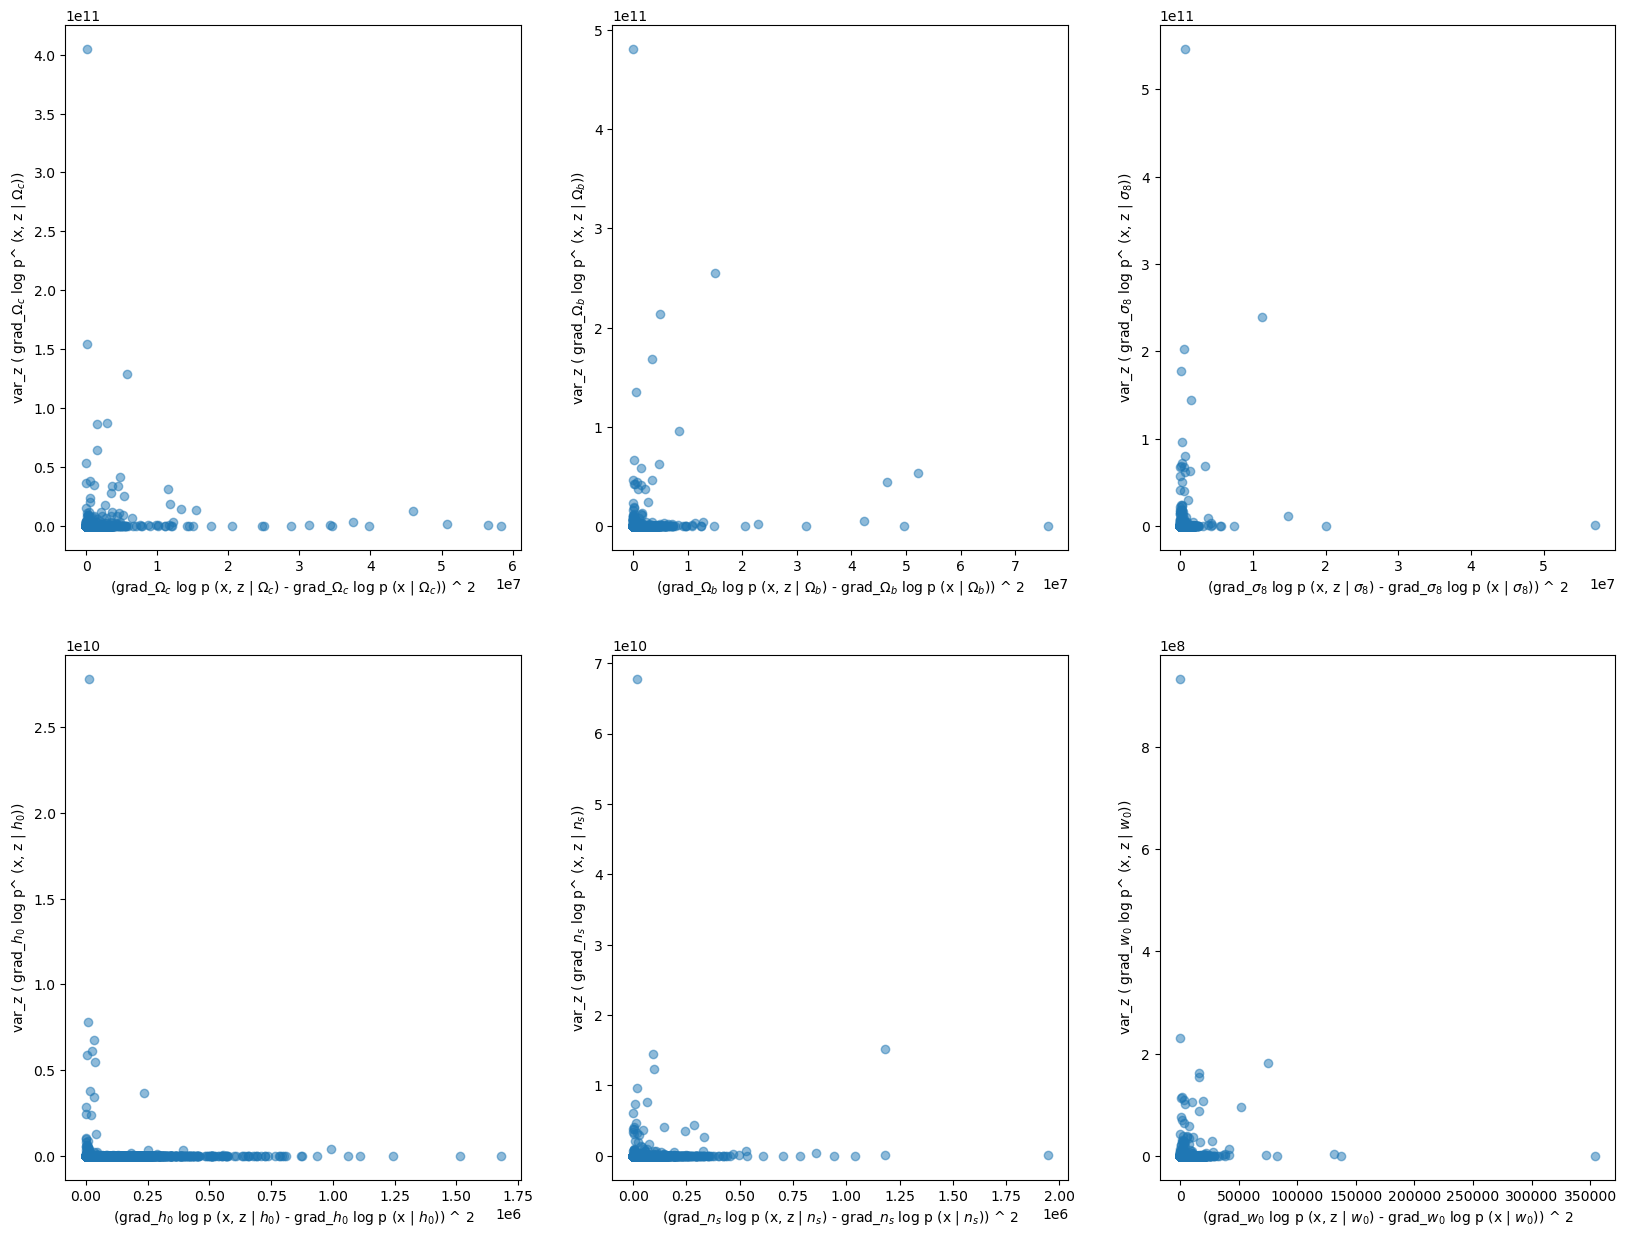

In [67]:
approx_esp, _ = get_moments_fixed.apply(params_esperance, state_bn_esp, dataset_theta_train, dataset_y_train)

var = (approx_esp - dataset_score_train) ** 2

approx_std, _ = get_moments_fixed.apply(params_std, state_bn_std, dataset_theta_train, dataset_y_train)
prediction = approx_std ** 2

plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var[...,i], prediction[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))
    
plt.savefig( "./SNR_study/regression_std_train.png")

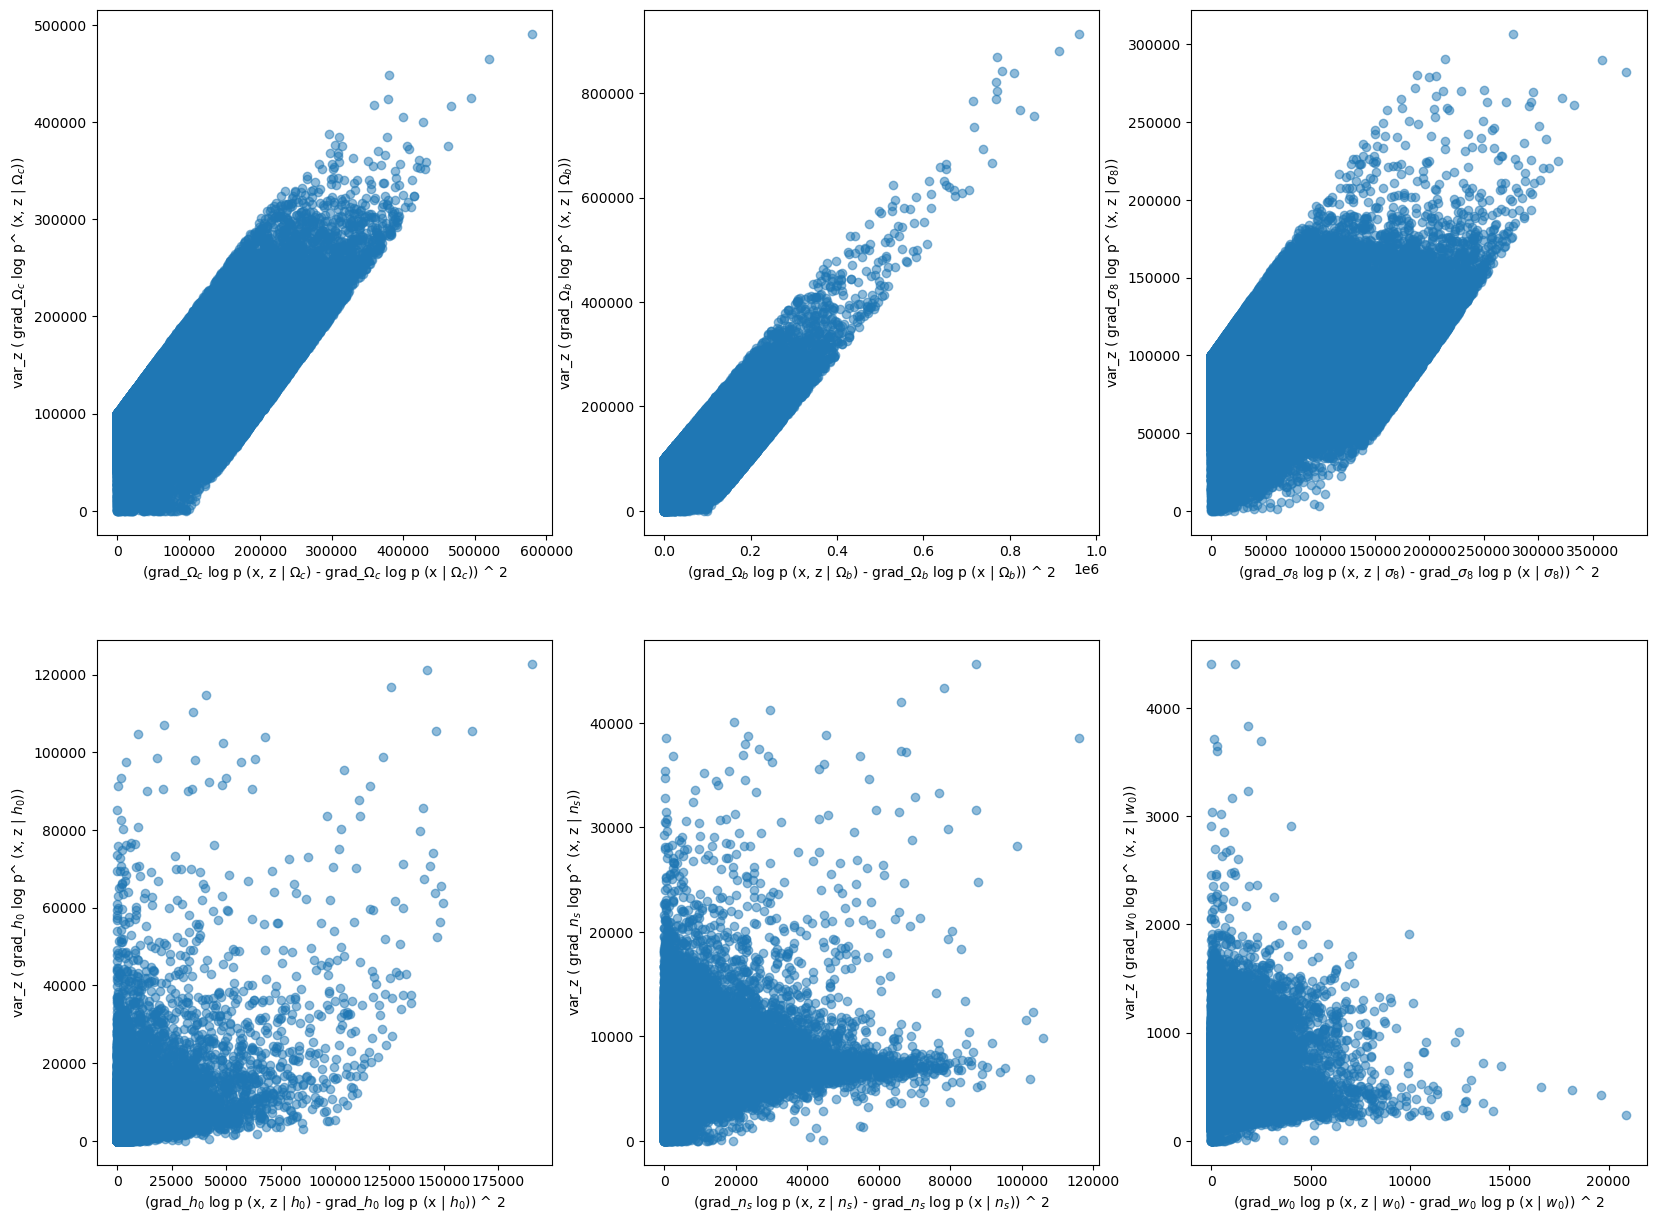

In [68]:
approx_esp, _ = get_moments_fixed.apply(params_esperance, state_bn_esp, dataset_theta_train, dataset_y_train)

var = (approx_esp - dataset_score_train) ** 2

approx_std, _ = get_moments_fixed.apply(params_std, state_bn_std, dataset_theta_train, dataset_y_train)
prediction = approx_std ** 2

inds = jnp.unique(jnp.where(jnp.abs(prediction - var) > 1e5)[0])

var_2 = jnp.delete(var, inds, axis = 0)
pred_2 = jnp.delete(prediction, inds, axis = 0)
    
plt.figure(figsize=(20,15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(var_2[...,i], pred_2[...,i], alpha = 0.5)
  plt.ylabel('var_z ( grad_{} log p^ (x, z | {}))'.format(params_name[i], params_name[i]))
  plt.xlabel('(grad_{} log p (x, z | {}) - grad_{} log p (x | {})) ^ 2'.format(params_name[i], params_name[i], params_name[i], params_name[i]))

plt.savefig( "./SNR_study/regression_std_train_zoom.png")

In [22]:
with open(
   "./SNR_study/params_std.pkl", "wb"
) as fp:
    pickle.dump(params_std, fp)

# Compute SNR

In [72]:
def get_SNR(theta, x):
    esperance, _ = get_moments_fixed.apply(params_esperance, state_bn_esp, theta, x)
    std, _ = get_moments_fixed.apply(params_std, state_bn_std, theta, x)
    return esperance / std ** 2

In [73]:
get_SNR(dataset_theta[-10:], dataset_y[-10:])

Array([[-1.2377828e-03, -1.5707709e-03, -1.8876630e-03, -8.2469443e-03,
        -5.0195004e-03,  2.7369015e-02],
       [ 7.1939013e-07,  6.4350251e-04, -5.4292509e-04, -3.2053903e-02,
        -6.7558205e-03, -7.8740943e-04],
       [ 5.9015874e-04,  4.0112823e-04,  8.2743593e-04,  6.7729922e-03,
         2.8237312e-03, -1.4662513e-02],
       [-2.2960929e-03, -2.0031019e-03, -1.1711292e-03, -6.6768602e-03,
        -5.3813360e-03, -2.5304076e-03],
       [ 1.6736913e-04, -4.5055564e-04, -5.2541064e-04,  1.1648892e-02,
         8.9918505e-03,  1.5108992e-04],
       [ 9.1111797e-05,  8.2045351e-04,  9.5747545e-04, -6.2983461e-02,
        -6.9835419e-03, -1.7519517e-02],
       [-7.4366387e-04, -9.3795260e-04, -1.0773685e-03,  4.9647456e-03,
         1.9171268e-03, -1.5374376e-03],
       [ 1.6504913e-03,  8.7583379e-04,  1.2716455e-03,  6.9361948e-04,
         3.2378400e-03, -8.2901958e-03],
       [-1.1024998e-03, -1.2007094e-03, -1.3278238e-03, -2.1496775e-02,
        -4.4084177e-03, 

In [75]:
esperance, _ = get_moments_fixed.apply(params_esperance, state_bn_esp, dataset_theta[-10:], dataset_y[-10:])
std, _ = get_moments_fixed.apply(params_std, state_bn_std, dataset_theta[-10:], dataset_y[-10:])

In [76]:
esperance

Array([[-1.80942780e+02, -1.57991257e+02, -1.50409378e+02,
        -9.16920853e+00, -3.06952362e+01,  1.54792471e+01],
       [ 1.00889765e-01,  8.52341309e+01, -3.62705688e+01,
        -2.45606537e+01, -3.83395500e+01, -5.63590109e-01],
       [ 4.71932602e+01,  2.60517139e+01,  1.05344940e+02,
         2.58729362e+01,  2.16485672e+01, -3.11062622e+00],
       [-1.83367538e+02, -8.19579315e+01, -1.52195786e+02,
        -2.76344872e+01, -4.50307732e+01, -4.80839789e-01],
       [ 2.24260826e+01, -4.89873428e+01, -4.64732361e+01,
         2.09138603e+01,  6.01731720e+01,  6.40806705e-02],
       [ 1.20890112e+01,  8.94142303e+01,  5.93988571e+01,
        -1.45498867e+01, -2.68284874e+01, -1.13180895e+01],
       [-8.98454056e+01, -9.75097580e+01, -1.05812065e+02,
         8.84476280e+00,  1.26208048e+01, -5.95539153e-01],
       [ 1.59098709e+02,  9.01827087e+01,  1.25532257e+02,
         2.55212784e+00,  2.15650444e+01, -2.50157428e+00],
       [-1.27689438e+02, -8.05590057e+01, -8.677

In [77]:
dataset_score[-10:]

array([[-7.2900134e+02, -4.9261115e+02, -3.2582993e+02, -5.9027786e+01,
        -1.1962431e+02,  6.5825963e+00],
       [ 5.3864484e+02,  7.0487982e+02,  2.6944739e+02, -4.8292175e+01,
         1.4513046e+01, -3.9271530e+01],
       [-1.6940820e+02, -1.8368866e+02, -2.3392888e+02, -9.5162964e-01,
        -2.0065529e+01, -6.3883481e+00],
       [ 9.7890251e+01,  4.3110413e+01,  1.2417829e+02,  3.0812927e+01,
         1.1052675e+02,  3.4641731e+01],
       [-2.6940369e+02, -1.3867508e+02, -3.1138721e+02, -3.7533539e+01,
        -5.5759499e+01, -5.9487438e-01],
       [-1.1927406e+02,  1.4320297e+02, -6.8339111e+01, -5.5141834e+01,
        -6.0544289e+01,  9.3456526e+00],
       [-5.0394522e+02, -4.6408392e+02, -4.9710678e+02, -2.3399269e+01,
        -1.1926052e+02,  9.4176769e+00],
       [-2.1445621e+01,  2.0003467e+02,  4.7595795e+01, -8.9020935e+01,
         7.1392601e+01, -5.1194882e+00],
       [-6.6778778e+02, -4.3613773e+02, -5.9154309e+02, -6.4632004e+01,
        -1.0217304e+02, 

In [78]:
std ** 2

Array([[146182.98   , 100581.99   ,  79680.2    ,   1111.831  ,
          6115.1978 ,    565.5756 ],
       [140243.47   , 132453.45   ,  66805.84   ,    766.22974,
          5675.04   ,    715.7523 ],
       [ 79967.06   ,  64946.098  , 127314.92   ,   3820.0156 ,
          7666.653  ,    212.14824],
       [ 79860.68   ,  40915.51   , 129956.445  ,   4138.8447 ,
          8367.954  ,    190.02464],
       [133991.75   , 108726.51   ,  88451.26   ,   1795.3519 ,
          6691.9683 ,    424.12274],
       [132683.27   , 108981.47   ,  62036.95   ,    231.01123,
          3841.6736 ,    646.02747],
       [120814.54   , 103960.21   ,  98213.44   ,   1781.5137 ,
          6583.187  ,    387.35828],
       [ 96394.766  , 102967.836  ,  98716.39   ,   3679.4353 ,
          6660.318  ,    301.75092],
       [115818.1    ,  67092.84   ,  65351.598  ,    544.60016,
          4781.633  ,    597.8528 ],
       [123556.586  ,  87216.84   ,  90261.79   ,   1890.2622 ,
          6908.2373 ,    35

In [79]:
std

Array([[-382.33884 ,  317.14664 ,  282.27682 ,   33.34413 ,  -78.19973 ,
         -23.781834],
       [-374.49094 ,  363.94156 ,  258.46826 ,   27.680855,  -75.33286 ,
         -26.753548],
       [-282.7845  ,  254.84525 ,  356.81216 ,   61.806274,  -87.559425,
         -14.56531 ],
       [-282.5963  ,  202.27583 ,  360.49472 ,   64.333855,  -91.476524,
         -13.784943],
       [-366.04883 ,  329.73703 ,  297.40756 ,   42.371593,  -81.80445 ,
         -20.59424 ],
       [-364.25714 ,  330.1234  ,  249.07217 ,   15.199054,  -61.981236,
         -25.41707 ],
       [-347.58386 ,  322.42862 ,  313.39023 ,   42.20798 ,  -81.13684 ,
         -19.68142 ],
       [-310.47507 ,  320.88602 ,  314.19165 ,   60.658348,  -81.61077 ,
         -17.37098 ],
       [-340.3206  ,  259.02286 ,  255.63959 ,   23.33667 ,  -69.14935 ,
         -24.451029],
       [-351.50616 ,  295.32498 ,  300.436   ,   43.477146,  -83.11581 ,
         -18.821672]], dtype=float32)

# Create new dataset with learned marginal score

In [135]:
# inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])

# dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
# dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
# dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)

# learned_marginal_score = get_moments.apply(params_esperance, dataset_score)
    
# dataset = {
#     'theta': dataset_theta, 
#     'score': learned_marginal_score, 
#     'y': dataset_y, 
# }

# # saving the dataset
# np.savez('LOADED&COMPRESSED_year_10_with_noise_score_conditional_marginal.npz', dataset)